## Hex World
Markov Decision Process

In [1]:
struct MDP
    γ # discount factor
    𝒮 # state space
    𝒜 # action
    T # transition function
    R # reward function
end

struct State
    x::Int32
    y::Int32
end

struct Action
    x::Int32
    y::Int32
end

Base.:+(s1::State, s2::Action) = State(s1.x + s2.x, s1.y + s2.y)

In [2]:
# 6 direction can take in one action 
const ACTIONS = ["→", "↗", "↖", "←", "↙", "↘"]
const MOVEMENTS = [Action(1, 0), Action(0, 1), Action(-1, 1), Action(-1, 0), Action(0, -1), Action(1, -1)] 
# terminal state 
const terminal_state = State(typemin(Int32), typemin(Int32))

const MOVE_TO_ARROW = Dict([MOVEMENTS[i] => ACTIONS[i] for i = 1 : length(MOVEMENTS)]) 

Dict{Action, String} with 6 entries:
  Action(1, -1) => "↘"
  Action(0, 1)  => "↗"
  Action(-1, 0) => "←"
  Action(1, 0)  => "→"
  Action(-1, 1) => "↖"
  Action(0, -1) => "↙"

Data structure for a Hex World MDP

In [3]:
struct HexWorldMDP
    mdp::MDP 
    # constructor
    function HexWorldMDP(
        γ::Real,                        # discount factor
        p_transision::Real,             # probablity of transitioning  to the correct next state
        reward_bump_border::Real,       # reward if go outside the hex world
        hexes::Vector{State},           # all state in hex world
        rewards::Dict{State, Real},     # reward in absorbing hex
        )

        T, R = constructTR(p_transision, reward_bump_border, hexes, rewards) 
        
        mdp = MDP(γ, hexes, MOVEMENTS, T, R)

        return new(mdp)
    end

    ### construct Transition and Reward table for all state
    function constructTR(
        p_transition::Real, 
        reward_bump_border::Real, 
        hexes::Vector{State}, 
        rewards::Dict{State, Real})
        
        nS = length(hexes) + 1  # plus one terminal state
        nA = length(MOVEMENTS)  # 6 action

        p_veer = (1 - p_transition) / 2     # unintented probablity

        R = Dict{Tuple{State, Action}, Real}()
        T = Dict{Tuple{State, Action, State}, Real}()
        for s in hexes
            if s in keys(rewards)    # Action taken from an absorbing hex 
                for α in MOVEMENTS
                    s′ = s + α
                    T[(s, α, s′)] = 0.0
                    T[(s, α, terminal_state)] = 1.0     # transports to terminal state
                    updateR(R, (s, α), rewards[s])            # get the reward
                end
            else 
                for (idx, α) in enumerate(MOVEMENTS)
                    # correct transition
                    s′ = s + α
                    updateR(R, (s, α), 0.0)
                    updateT(T, (s, α, s′), 0.0)
                    updateT(T, (s, α, s), 0.0)

                    if !(s′ in hexes)   # out of the map
                        s′ = s
                        updateR(R, (s, α), reward_bump_border * p_transition)
                    end
                    updateT(T, (s, α, s′), p_transition)

                    # unintented verr left
                    s′ = s + MOVEMENTS[mod1(idx + 1, nA)]
                    if !(s′ in hexes)   # out of the map
                        s′ = s
                        updateR(R, (s, α), reward_bump_border * p_veer)
                    end
                    updateT(T, (s, α, s′), p_veer)

                    # unintented verr right
                    s′ = s + MOVEMENTS[mod1(idx - 1, nA)]
                    if !(s′ in hexes)   # out of the map
                        s′ = s
                        updateR(R, (s, α), reward_bump_border * p_veer)
                    end
                    updateT(T, (s, α, s′), p_veer)
                end
            end
        end
        # absorbing state stays
        for α in MOVEMENTS
            T[terminal_state, α, terminal_state] = 1.0
        end
        
        return T, R
    end

    function updateR(R::Dict{Tuple{State, Action}, Real}, key::Tuple{State, Action}, value::Real)
        if (!haskey(R, key))
            R[key] = 0.0
        end
        R[key] += value
    end

    function updateT(T, key::Tuple{State, Action, State}, value::Real)
        if (!haskey(T, key))
            T[key] = 0.0
        end
        T[key] += value
    end
end

In [4]:
# function for hex world mdp
inbounds(hexMDP::HexWorldMDP, s::State) = s in hexMDP.mdp.𝒮

function T(mdp::MDP, s::State, α::Action, s′::State)
    if !haskey(mdp.T, (s, α, s′))
        return 0.0
    end
    return mdp.T[(s, α, s′)]
end

function R(mdp::MDP, s::State, α::Action)
    if !haskey(mdp.R, (s, α))
        return 0.0
    end
    return mdp.R[(s, α)]
end

is_terminal(s::State) = s == terminal_state 
n_states(mdp::HexWorldMDP) = length(mdp.mdp.𝒮) + 1  # plus one terminal state

n_states (generic function with 1 method)

## Markov Decision Process - Value Iteration

In [5]:
# computing lookahead state-action value from s given action α
function lookahead(𝒫::MDP, U, s::State, α::Action)
    𝒮, γ = 𝒫.𝒮, 𝒫.γ
    return R(𝒫, s, α) + γ * sum(T(𝒫, s, α, s′) * U[i] for (i, s′) in enumerate(𝒮))
end 

lookahead (generic function with 1 method)

In [6]:
# backup procedure improve value function U at state s
# return u, optimal policy α for state s
function backup(𝒫::MDP, U, s::State)
    u, idx = findmax([lookahead(𝒫, U, s, α) for α in 𝒫.𝒜])
    return (u = u, α = 𝒫.𝒜[idx])
end

backup (generic function with 1 method)

In [7]:
# solve Hex world MDP, repeat until ||U - U′|| < δ
δ = 1e-16   # threshold

# return value function, and optimal policy for each state
function solve(𝒫::HexWorldMDP)
    𝒮, γ = 𝒫.mdp.𝒮, 𝒫.mdp.γ
    U = zeros(length(𝒮))
    π = Dict{State, Action}()
    iter = 0
    while true
        iter += 1
        U′ = zeros(length(𝒮))
        for (i, s) in enumerate(𝒮)
            U′[i], π[s] = backup(𝒫.mdp, U, s)
        end
        if (sqrt(sum((U - U′) .^ 2)) < δ)
            break
        end
        U = U′
    end
    println("Total iter = ", iter)
    return U, π
end

solve (generic function with 1 method)

Cấu hình cho Hex World cần giải

In [8]:
# cấu hình thử nghiệm 1
discount = 0.5
reward_bump_border = -1.0
p_trans = 0.7
hexes = [   State(0, 0), State(1, 0), State(2, 0), State(3, 0), State(0, 1), State(1, 1), State(2, 1), State(-1, 2), 
            State(0, 2), State(1, 2), State(2, 2), State(3, 2), State(4, 2), State(5, 2), State(6, 2), State(7, 2), 
            State(8, 2), State(4, 1), State(5, 0), State(6, 0), State(7, 0), State(7, 1), State(8, 1), State(9, 0) ]
rewards = Dict{State, Real}(
    State(0, 1) => -5.0, 
    State(2, 0) => 5.0, 
    State(9, 0) => 6.0,
    State(2, 4) => -1.0)

mdp = HexWorldMDP(discount, p_trans, reward_bump_border, hexes, rewards);

In [9]:
# cấu hình thử nghiệm 2
discount = 0.9
reward_bump_border = -1.0
p_trans = 0.7
hexes = [   State(0, 0), State(1, 0), State(2, 0), State(3, 0), State(0, 1), State(1, 1), State(2, 1), State(-1, 2), 
            State(0, 2), State(1, 2), State(2, 2), State(3, 2), State(4, 2), State(5, 2), State(6, 2), State(7, 2), 
            State(8, 2), State(4, 1), State(5, 0), State(6, 0), State(7, 0), State(7, 1), State(8, 1), State(9, 0) ]
rewards = Dict{State, Real}(
    State(0, 1) => 5.0, 
    State(2, 0) => -10.0, 
    State(9, 0) => 10.0)

mdp = HexWorldMDP(discount, p_trans, reward_bump_border, hexes, rewards);

In [10]:
U, π = solve(mdp);

Total iter = 45


## SIMULATOR

Các hàm hỗ trợ giả lập ngẫu nhiên trò chơi

In [11]:

sample(items, weight) = items[findfirst(cumsum(weight) .> rand())]

generate_start_state(mdp::HexWorldMDP) = mdp.mdp.𝒮[rand(1:(n_states(mdp) - 1))]

# generate next state random from state s with action α
function generate_next_state(hexMDP::HexWorldMDP, s::State, α::Action)
    𝒜 = hexMDP.mdp.𝒜
    probability = []
    S′ = []
    # generate all posible movement after taken action α from s
    for α′ in [𝒜; Action(0, 0)]
        s′ = s + α′
        if (T(hexMDP.mdp, s, α, s′) > 0.0)
            push!(probability, T(hexMDP.mdp, s, α, s′))
            push!(S′, s′)
        end
    end 
    # check if go to terminal state after receive reward
    if T(hexMDP.mdp, s, α, terminal_state) > 0.0
        push!(probability, T(hexMDP.mdp, s, α, terminal_state))
        push!(S′, terminal_state)
    end    
    # random select in prob action
    s′ = sample(S′, probability)
    α′ = Action(s′.x - s.x, s′.y - s.y)
    if s′ == s # stay
        idx = findfirst(h -> h == α, 𝒜)
        for i in [mod1(idx - 1, 6), idx, mod1(idx + 1, 6)]
            if !inbounds(hexMDP, s + 𝒜[i])
                α′ = 𝒜[i]
                break
            end
        end
    elseif s′ == terminal_state
        α′ = 𝒜[1]
    end
    return s′, α′
end
# simulate start at start_state, follow policy π
function simulation(hexMDP::HexWorldMDP, π, start_state::State; show_step = false)
    S, R, T, γ = hexMDP.mdp.𝒮, hexMDP.mdp.R, hexMDP.mdp.T, hexMDP.mdp.γ
    if !(start_state in S)
        return 0.0
    end
    s = start_state
    total_reward = 0.0
    step = 0
    while true
        
        if haskey(rewards, s)
            total_reward += (γ ^ step) * rewards[s] 
        end
        # next state action by random 
        s′, α′ = generate_next_state(hexMDP, s, π[s])
        
        # if stay -> bump the border
        if s′ == s
            total_reward += (γ ^ step) * reward_bump_border
        end

        if show_step   # print out step and direction arrow
            print('(', s.x, ", ", s.y, ')')
            println(' ', MOVE_TO_ARROW[π[s]], ' ', MOVE_TO_ARROW[α′], ' ', total_reward)
        end

        # if next state is terminal then terminate game
        if is_terminal(s′)
            break
        end

        step += 1
        s = s′
    end
    return total_reward
end


simulation (generic function with 1 method)

In [12]:
U, π = solve(mdp);
@time simulation(mdp, π, State(4, 1), show_step = true);

Total iter = 

45
(4, 1) ↗ ↗ 0.0


(4, 2) → ↘ -0.9
(4, 2) → ↘ -1.71
(4, 2) → → -1.71
(5, 2) → ↘ -2.3661
(5, 2) → → -2.3661
(6, 2) → ↘ -2.3661
(7, 1) → → -2.3661
(8, 1) ↘ ↘ -2.3661
(9, 0) → → 1.5081048900000011


  3.126976 seconds (1.68 M allocations: 99.046 MiB, 0.62% gc time, 24.42% compilation time)


### Monte Carlo Simulation
Thực nghiệm trên cùng một bản đồ và trạng thái xuất phát trong Hex World, lấy trung bình cộng của các lần thử nghiệm

In [13]:
function MonteCarloSimulation(hexMDP::HexWorldMDP, num_iter::Int)
    𝒮 = hexMDP.mdp.𝒮
    start_state = generate_start_state(hexMDP)
    total = 0.0
    for iter = 1 : num_iter
        total += simulation(mdp, π, start_state)
    end
    println("Number of iteration: ", num_iter)
    println("Start state: ", start_state)
    println("Mean = ", total / num_iter)
    println("Expected utility = ", U[findfirst(h -> h == start_state, 𝒮)])
end

MonteCarloSimulation (generic function with 1 method)

In [14]:
@time MonteCarloSimulation(mdp, 100000)

Number of iteration: 100000
Start state: 

State(1, 1)
Mean = 4.306621292369945
Expected utility = 4.308361926449785
  2.442034 seconds (16.70 M allocations: 545.223 MiB, 3.37% gc time, 38.49% compilation time)


## Visualization
Các hàm dưới đây dùng để hỗ trợ visualize trực quan kết quả

In [ ]:
import Pkg;
if !haskey(Pkg.dependencies(), "Plots")
    Pkg.add("Plots")
end

using Plots

In [16]:
rectangle(w, h, x, y) = Shape(x .+ [0,w,w,0], y .+ [0,0,h,h])
# render hex world map with value function U, policy π
function render(hexMDP::HexWorldMDP, U, π; tit = "", current_state = nothing)
    # constant setting plot
    diff_x = 0.62
    diff_y = 0.6
    diff_odd = 0.3
    direct = Dict([(MOVEMENTS[1], (1, 0)), (MOVEMENTS[2], (1, 1)),
                (MOVEMENTS[3], (-1, 1)), (MOVEMENTS[4], (-1, 0)),
                (MOVEMENTS[5], (-1, -1)), (MOVEMENTS[6], (1, -1))])

    S = hexMDP.mdp.𝒮    
    R = hexMDP.mdp.R    
    
    X = [(s.x * diff_x + diff_odd * s.y) for s in S]
    Y = [(s.y * diff_y) for s in S]
    # setup grad color
    colors = [(u - minimum(values(R))) / (maximum(values(R)) - minimum(values(R))) for u in U]
    fig = scatter(X, Y, 
        m = cgrad(:RdBu_9),
        zcolor = colors,
        markershape = :hexagon, 
        makerstrokewidth = 5,
        markersize = 25, 
        legend = nothing,
        axis = nothing,
        title = tit
        )
    if current_state != nothing
        scatter!([current_state.x * diff_x + diff_odd * current_state.y], 
                [current_state.y * diff_y],
                m = cgrad(:RdBu_9),
                zcolor = [colors[findfirst(h -> h == current_state, S)]],
                markershape = :hexagon,
                markersize = 25,
                markerstrokewidth = 5,
                markerstrokealpha = 0.0,
                markerstrokecolor = :green,
                )
    end
    for s in S
        x = s.x * diff_x + diff_odd * s.y
        y = s.y * diff_y
        dx, dy = direct[π[s]]
        dx /= 100; dy /= 100
        x += dx * 15
        y += dy * 15
        plot!([x, x + dx], [y, y + dy], arrow = true, linewidth = 2, color = :black)
    end

    plot!(rectangle(7, 5, -1, -2), opacity = 0.0)
end

render (generic function with 1 method)

Total iter = 45

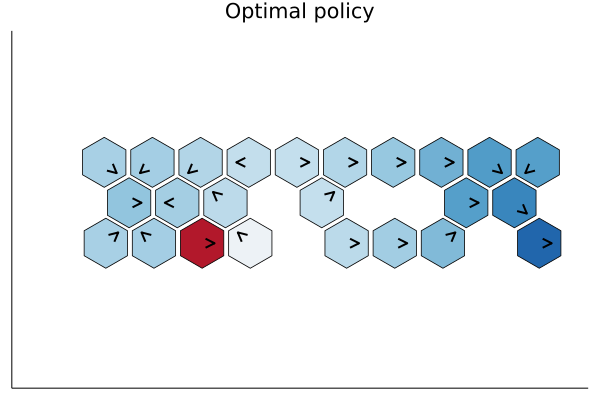

In [17]:
mdp = HexWorldMDP(discount, p_trans, reward_bump_border, hexes, rewards);
U, π = solve(mdp);
render(mdp, U, π, tit = "Optimal policy")